In [1]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [2]:
fn="cobi_state_data.csv"
df=pd.read_csv(fn)

In [3]:
rsspeedmax=10.
userPowermax=100.
ridingDurationmax=500.
ridingDistancemax=2000.
ascentmax=15.
caloriesmax=50.
heartratemax=150.
cadencemax=90.
averageSpeedmax=8.

df['rsspeed']=df['rsspeed']/rsspeedmax
df['userPower']=df['userPower']/userPowermax
df['ridingDuration']=df['ridingDuration']/ridingDurationmax
df['ridingDistance']=df['ridingDistance']/ridingDistancemax
df['ascent']=df['ascent']/ascentmax
df['calories']=df['calories']/caloriesmax
df['heartRate']=df['heartRate']/heartratemax
df['cadence']=df['cadence']/cadencemax
df['averageSpeed']=df['averageSpeed']/averageSpeedmax


In [4]:
cols=[col for col in df.columns ]
cols

['rsspeed',
 'userPower',
 'ridingDuration',
 'ridingDistance',
 'ascent',
 'calories',
 'heartRate',
 'cadence',
 'averageSpeed']

In [5]:
dftrain,dftest=train_test_split(df,test_size=0.15)
dftest['Class']=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
numinps= len(cols)
numinps

9

<p>Test/Train split for train and eval data.</p>

In [7]:
dftrain2,dfeval=train_test_split(dftrain,test_size=0.15)

<p>Building the autoencoder</p>

<p>So the Threshold is determined below and then put into the model as hardwired (not used to determine the threshold - no loops here) so that we can export the model at the same time.</p>

In [8]:
encodedim=14
hiddim=encodedim//2
learnrate=0.001
droprate=0.2
thresh=0.15 #picked as just above max value to detect anything outside the norm
threshold=tf.constant(thresh)
inputs=tf.placeholder(tf.float32, shape=(None,numinps),name="inputs")
#mode=tf.placeholder(tf.string, name="mode")

dense0 = tf.layers.dense(inputs=inputs, units=encodedim, activation=tf.nn.tanh)
dropout0 = tf.layers.dropout(inputs=dense0, rate=droprate)

dense1 = tf.layers.dense(inputs=dropout0, units=hiddim, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=droprate)

dense2 = tf.layers.dense(inputs=dropout1, units=hiddim, activation=tf.nn.tanh)
dropout2 = tf.layers.dropout(inputs=dense2, rate=droprate)

dense3 = tf.layers.dense(inputs=dropout2, units=numinps, activation=tf.nn.relu)
dropout3 = tf.layers.dropout(inputs=dense3, rate=droprate)

loss=tf.losses.mean_squared_error(labels=inputs,predictions=dropout3)
Yout=tf.cast(tf.math.greater(loss,0.15), tf.int32)
trainstep=tf.train.AdamOptimizer(learning_rate=learnrate).minimize(loss)


<p>Training Autoencoder and then exporting saved_model format.</p>

In [9]:
init = tf.global_variables_initializer()
batchsize=100
#xbatch=dftrain2.loc[:,cols].head(10).values
evalbatch=dfeval[cols]
numepochs=4

treerr=[]
everr=[]
modeldir="m_{:05d}".format(np.random.randint(100000))

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(numepochs):
        for i in range(dftrain2.shape[0]//batchsize):
            xbatch=dftrain2.iloc[i*batchsize:(i+1)*batchsize][cols]
            _,ltr=sess.run([trainstep,loss],feed_dict={inputs:xbatch})
            print("train: ",epoch,i,ltr)
            if i%20==0:
                l=sess.run([loss],feed_dict={inputs:evalbatch})
                print("evalu: ",epoch,i,l)
                treerr.append(ltr)
                everr.append(l)
     
    print("Running Test data...")
    out=[]
    for i in range(dftest.shape[0]):
        testbatch=np.array([dftest.iloc[i][cols].values])
        l=sess.run([loss,Yout],feed_dict={inputs:testbatch})
        out.append([dftest.iloc[i]['Class'],l[0],l[1]])
    tf.saved_model.simple_save(sess,modeldir, inputs=
                           {
                               "inputs":inputs#,'labels':labels,"learnrate":learnrate,"droprate":droprate,"mode":mode
                           },
                           outputs={"Yout":Yout,"loss":loss}#,"batchloss":batchloss}
                          )

train:  0 0 0.28222603
evalu:  0 0 [0.27617252]
train:  0 1 0.27981907
train:  0 2 0.2728107
train:  0 3 0.26185098
train:  0 4 0.2674988
train:  0 5 0.25449082
train:  0 6 0.2588505
train:  0 7 0.25489497
train:  0 8 0.23951471
train:  0 9 0.23507762
train:  0 10 0.23550819
train:  0 11 0.23188327
train:  0 12 0.2229608
train:  0 13 0.21053942
train:  0 14 0.21290024
train:  0 15 0.21012427
train:  0 16 0.19186324
train:  0 17 0.18269412
train:  0 18 0.19180523
train:  0 19 0.18047455
train:  0 20 0.17494008
evalu:  0 20 [0.16911955]
train:  0 21 0.17408651
train:  0 22 0.16656277
train:  0 23 0.15786509
train:  0 24 0.15482333
train:  0 25 0.15003018
train:  0 26 0.13755377
train:  0 27 0.12789214
train:  0 28 0.12814292
train:  0 29 0.12426077
train:  0 30 0.11562147
train:  0 31 0.115440056
train:  0 32 0.110404395
train:  0 33 0.102971956
train:  0 34 0.09373724
train:  0 35 0.09280446
train:  0 36 0.090830944
train:  0 37 0.089277774
train:  0 38 0.082571484
train:  0 39 0.078476

train:  2 0 0.018751033
evalu:  2 0 [0.017854804]
train:  2 1 0.019299421
train:  2 2 0.018682117
train:  2 3 0.020691007
train:  2 4 0.016721394
train:  2 5 0.018788125
train:  2 6 0.01642155
train:  2 7 0.016533727
train:  2 8 0.019267486
train:  2 9 0.01943687
train:  2 10 0.017053578
train:  2 11 0.0158842
train:  2 12 0.016729573
train:  2 13 0.01921149
train:  2 14 0.016238991
train:  2 15 0.0181457
train:  2 16 0.0163196
train:  2 17 0.018049074
train:  2 18 0.017524753
train:  2 19 0.020719385
train:  2 20 0.01706392
evalu:  2 20 [0.016971007]
train:  2 21 0.015943157
train:  2 22 0.015871897
train:  2 23 0.018961368
train:  2 24 0.01589475
train:  2 25 0.016765773
train:  2 26 0.015727911
train:  2 27 0.016875202
train:  2 28 0.018107248
train:  2 29 0.018536787
train:  2 30 0.015247074
train:  2 31 0.018358467
train:  2 32 0.015185305
train:  2 33 0.017137803
train:  2 34 0.015638644
train:  2 35 0.017542256
train:  2 36 0.015552823
train:  2 37 0.016040161
train:  2 38 0.016

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: m_72910/saved_model.pb


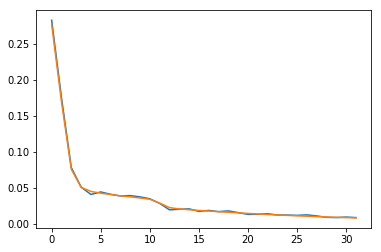

In [10]:
plt.plot(treerr)
plt.plot(everr)

In [11]:
out=np.array(out)
dfout=pd.DataFrame(data={"label":out[:,0],"err":out[:,1],"predicted":out[:,2]})
dfout.describe()

,label,err,predicted
count,3288.0,3288.000000,3288.0
mean,0.0,0.008406,0.0
std,0.0,0.008021,0.0
min,0.0,0.000664,0.0
25%,0.0,0.003249,0.0
50%,0.0,0.005915,0.0
75%,0.0,0.010446,0.0
max,0.0,0.081661,0.0


In [12]:
dfout

,label,err,predicted
0,0.0,0.026764,0.0
1,0.0,0.002391,0.0
2,0.0,0.004854,0.0
3,0.0,0.001613,0.0
4,0.0,0.024121,0.0
5,0.0,0.003875,0.0
6,0.0,0.003185,0.0
7,0.0,0.005945,0.0
8,0.0,0.000930,0.0
9,0.0,0.002634,0.0


In [13]:
dfout.describe().loc['mean','err']+dfout.describe().loc['std','err']

0.01642723413676222

In [14]:
thresh2=dfout.describe().loc['mean','err']+dfout.describe().loc['std','err']
print("thresh2 of err = mean+std = ",thresh2)
dfout['pred2']=0
dfout.loc[dfout['err']>thresh2,'pred2']=1
dfout.pred2.sum()/df.shape[0]

thresh2 of err = mean+std =  0.01642723413676222


0.015833903718913987

In [15]:
#Defining Prediction from loss
print(thresh)
dfout['pred']=0
dfout.loc[dfout['err']>thresh,'pred']=1

0.15


In [16]:
dfout.describe()

,label,err,predicted,pred2,pred
count,3288.0,3288.000000,3288.0,3288.000000,3288.0
mean,0.0,0.008406,0.0,0.105535,0.0
std,0.0,0.008021,0.0,0.307289,0.0
min,0.0,0.000664,0.0,0.000000,0.0
25%,0.0,0.003249,0.0,0.000000,0.0
50%,0.0,0.005915,0.0,0.000000,0.0
75%,0.0,0.010446,0.0,0.000000,0.0
max,0.0,0.081661,0.0,1.000000,0.0


In [17]:
testbatch.shape

(1, 9)

In [18]:
testbatch

array([[0.46061829, 0.8       , 0.34281054, 0.57682829, 0.69224514,
        0.36265347, 0.74666667, 0.32222222, 0.84132227]])